# Effect of House Characteristics on Their Prices 
## by Lubomir Straka

## Investigation Overview

In this investigation, I wanted to look at the key characteristics of houses that could be used to predict their prices. The main focus was on three aspects: above grade living area representing space characteristics, overall quality of house's material and finish representing physical characteristics, and neighborhood cluster representing location characteristics.

## Dataset Overview

The data consists of information regarding 1460 houses in Ames, Iowa, including their sale price, physical characteristics, space properties and location within the city as provided by [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The data set contains 1460 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values. These 79 explanatory variables plus one response variable (sale price) describe almost every aspect of residential homes in Ames, Iowa.

In addition to some basic data type encoding, missing value imputing and cleaning, four outliers were removed from the analysis due to unusual sale conditions.

In [12]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [13]:
# Load the Ames Housing dataset
path = 'https://raw.githubusercontent.com/lustraka/Data_Analysis_Workouts/main/Communicate_Data_Findings/ames_train_data.csv'
ames = pd.read_csv(path, index_col='Id')
################
# Wrangle data #
################
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(pd.CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

# Pre-process data
ames = encode_dtypes(ames)
ames = impute_missing(ames)
ames = clean_data(ames)

# Add log transformed SalePrice to the dataset
ames['logSalePrice'] = ames.SalePrice.apply(np.log10)

## Distribution of House Prices
**Graph on left**

The values of the response variable *SalePrice* are distributed between \$34.900 and \$755.000 with one mode at \$140.000, which is lower than the median at \$163.000, which is lower than the average price of \$180.921. The distribution of *SalePrice* is asymmetric with relatively few large values and tails off to the right. It is also relatively peaked. 

**Graph on right**

For analysis of the relationships with other variables would be more suitable a log transformation of *SalePrice*. The distribution of *logSalePrice* is almost symmetric with skewness close to zero although the distribution is still a bit peaked.


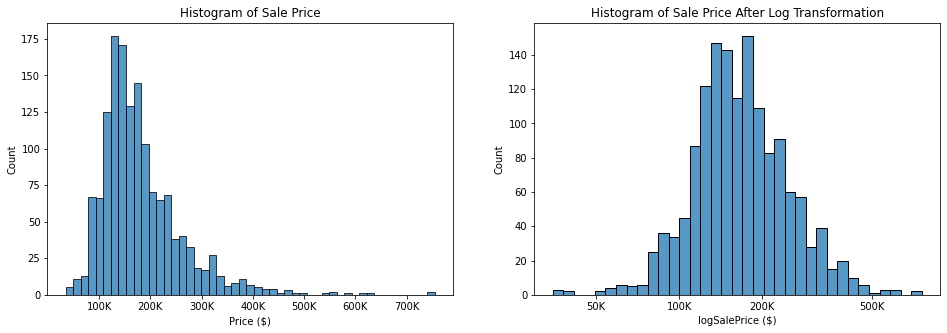

In [36]:
def log_trans(x, inverse=False):
  """Get log or tenth power of the argument."""
  if not inverse:
    return np.log10(x)
  else:
    return 10**x

# Plot SalePrice with a standard and log scale
fig, axs = plt.subplots(1, 2, figsize=[16,5])
# LEFT plot
sns.histplot(data=ames, x='SalePrice', ax=axs[0])
axs[0].set_title('Distribution of Sale Price')
xticks = np.arange(100000, 800000, 100000)
axs[0].set_xticks(xticks)
axs[0].set_xticklabels([f'{int(xtick/1000)}K' for xtick in xticks])
axs[0].set_xlabel('Price ($)')
# RIGHT plot
sns.histplot(data=ames, x='logSalePrice', ax=axs[1])
axs[1].set_title('Distribution of Sale Price After Log Transformation')
lticks = [50000, 100000, 200000, 500000]
axs[1].set_xticks(log_trans(lticks))
axs[1].set_xticklabels([f'{int(xtick/1000)}K' for xtick in lticks])
axs[1].set_xlabel('Price ($)')
plt.show()

## Distribution of Living Area

The distribution of above grade living area (*GrLivArea*) is asymmetrical with skewness to the right and some peakness. There was two partial sales (houses not completed), one abnormal sale (trade, foreclosure, or short sale), and one normal, just simply unusual sale (very large house priced relatively appropriately). These outliers (any houses with *GrLivArea* greater then 4000 square feet) had been removed. This is a distribution of the cleaned dataset.

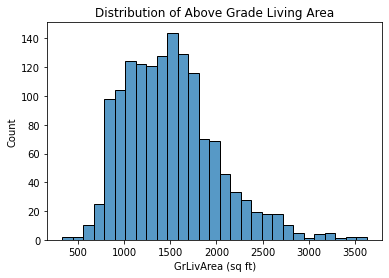

In [37]:
# Remove outliers
ames = ames.query('GrLivArea < 4000').copy()

# Plot a distribution of GrLivArea
sns.histplot(data=ames, x='GrLivArea')
plt.title('Distribution of Above Grade Living Area')
plt.xlabel('GrLivArea (sq ft)')
plt.show()

## Sale Price vs Overall Quality
Overall Quality (*OverallQual*) represents physical aspects of the building and rates the overall material and finish of the house. The moset frequent value of this categorical variable is average rate (5). The violin plot of sale price versus overall quality illuminates positive correlation between these variables. The higher the quality, the higher the price.

Interestingly, it looks like the missing values occur exclusively in observations with the best overall quality.


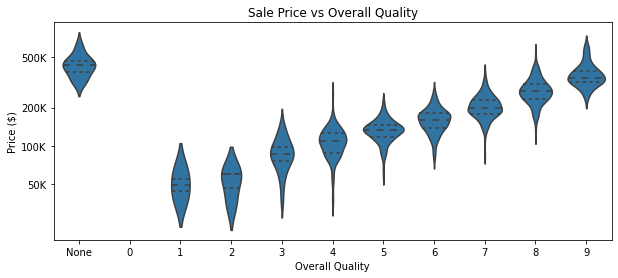

In [41]:
# Set the base color
base_color = sns.color_palette()[0]

# Show violin plot
plt.figure(figsize=(10,4))
sns.violinplot(data=ames, x='OverallQual', y='logSalePrice', color=base_color, inner='quartile')
plt.ylabel('Price ($)')
plt.yticks(log_trans(lticks), [f'{int(xtick/1000)}K' for xtick in lticks])
plt.xlabel('Overall Quality')
plt.title('Sale Price vs Overall Quality')
plt.show()

## Sale Price vs Neighborhood
Neighborhood represent the place where the house is located. The most frequent in the dataset are houses from North Ames (15 %) followed by houses from College Creek (10 %) and Old Town (8 %). To get insight into the effect of the nominal variable *Neighborhood* I had to cluster neighborhoods according to unit price per square feet. The violin plot of sale price versus three neighborhood clusters shows a positive correlation between these variables.

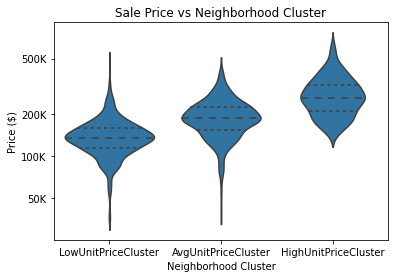

In [42]:
# Add a variable with total surface area
ames['TotalSF'] = ames['TotalBsmtSF'] + ames['1stFlrSF'] + ames['2ndFlrSF'] + ames['GarageArea']
# Calculate price per square feet
ames['SalePricePerSF'] = ames.SalePrice / ames.TotalSF

# Cluster neighborhoods into three clusters
ngb_mean_df = ames.groupby('Neighborhood')['SalePricePerSF'].mean().dropna()
bins = np.linspace(ngb_mean_df.min(), ngb_mean_df.max(), 4)
clusters = ['LowUnitPriceCluster', 'AvgUnitPriceCluster', 'HighUnitPriceCluster']
# Create a dict 'Neighborhood' : 'Cluster'
ngb_clusters = pd.cut(ngb_mean_df, bins=bins, labels=clusters, include_lowest=True).to_dict()

# Add new feature to the dataset
ames['NgbCluster'] = ames.Neighborhood.apply(lambda c: ngb_clusters.get(c, "")).astype(pd.CategoricalDtype(clusters, ordered=True))

# Plot the new feature
sns.violinplot(data=ames, x='NgbCluster', y='logSalePrice', color=base_color, inner='quartile')
plt.xlabel('Neighborhood Cluster')
plt.ylabel('Price ($)')
plt.yticks(log_trans(lticks), [f'{int(xtick/1000)}K' for xtick in lticks])
plt.title('Sale Price vs Neighborhood Cluster')
plt.show()

## Sale Price vs Living Area and Location
Two previous figures showed a positive correlation between building and location variables and sale price. Now, let's look at the relation between a space variable *GrLivArea* and price. The scatter plot of sale price versus living area with colored neighborhood clusters justifies the approximately linear relationship between price on one side and living area and location on the other side.

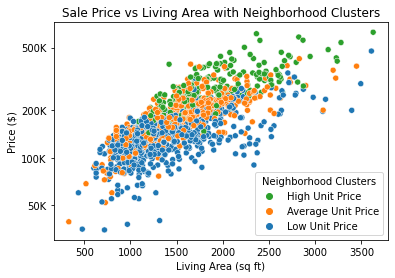

In [45]:
# Combine space and location variables
ax = sns.scatterplot(data=ames, x='GrLivArea', y='logSalePrice', hue='NgbCluster')
plt.title('Sale Price vs Living Area with Neighborhood Clusters')
plt.xlabel('Living Area (sq ft)')
plt.ylabel('Price ($)')
plt.yticks(log_trans(lticks), [f'{int(xtick/1000)}K' for xtick in lticks])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['High Unit Price', 'Average Unit Price', 'Low Unit Price'], title='Neighborhood Clusters')
plt.show()

## Sale Price vs Overall Quality by Location

Finally, let's look at combination of overall quality and neighborhood clusters. These violin plots of sale price versus overall quality show differences between neighborhood clusters. The most diverse cluster in regards to overall quality of houses is the one with lower unit price per square feet. As expected, houses in the cluster with high unit prices per square feet have better overall quality as wall as higer prices.

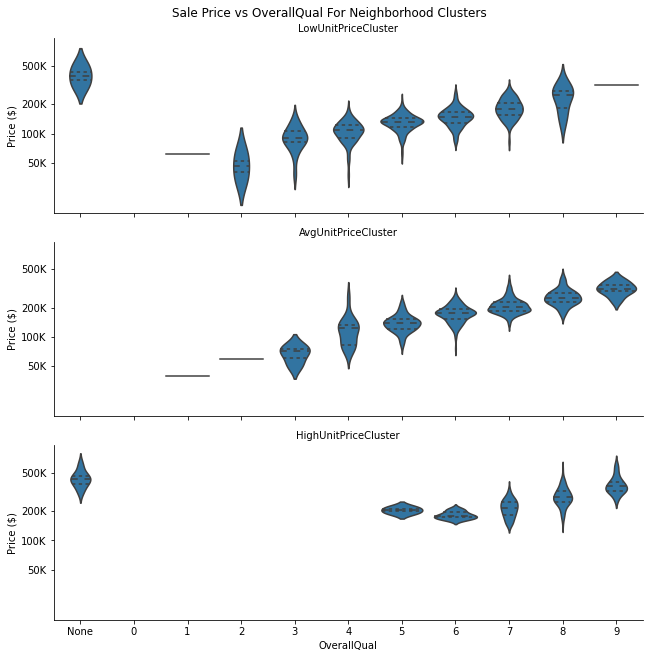

In [49]:
# Combine building and location variables
g = sns.FacetGrid(data=ames, row='NgbCluster', aspect=3)
g.map(sns.violinplot, 'OverallQual', 'logSalePrice', inner='quartile')
g.set_titles('{row_name}')
g.set(yticks=log_trans(lticks), yticklabels=[f'{int(xtick/1000)}K' for xtick in lticks])
g.set_ylabels('Price ($)')
g.fig.suptitle('Sale Price vs OverallQual For Neighborhood Clusters', y=1.01)
plt.show()

## Conclusion

The investigation justified that the three selected explanatory variables of house can be used to predict the house sale price (a response variable). These variable are namely: 
- *above grade living area* representing space characteristics, 
- *overall quality* of house's material and finish representing physical characteristics, and 
- *neighborhood cluster* representing location characteristics; this variable was engineered by clustering neighborhoods according to unit price per square feet. 

All these variables have a positive relationship with sale price of the house.

## Thanks For Your Attention
Finished 2021-11-18

In [ ]:
# !jupyter nbconvert Part_II_slide_deck_ames.ipynb --to slides --post serve --no-input --no-prompt